# Meta-Questions Detection

This notebook demonstrates the analysis of training the `distil-BERT` model which classifies texts into meta and no-meta questions.

Our main evaluation metric is **F1-Score**. We also calculate accuracy.

This notebook runs in the Google Colab enviroment.

# Install the required packages.

In [ ]:
!pip install transformers # supports Transformer-based models
!pip install datasets # datasets for experiments
!pip install evaluate # evaluation metrics for experiments
!pip install transformers[torch] # backend for training

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 751.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl 

In [ ]:
from transformers.utils import logging

logging.set_verbosity_error()

Next, import pandas to manipulate data and fix the random seed abnd tqdm to control exec time .

In [ ]:
import pandas as pd # data manipulation & storage
from tqdm.auto import tqdm

In [ ]:
from transformers import set_seed # fix random seed
set_seed(0)

## Create the dataset


In [1]:
import gdown

In [ ]:
train_dataset_url = "https://drive.google.com/uc?export=download&id=1h_V3uZua-x8oeHR9rxlhj_r_gWVqUZqI"

train_dataset_name = "nometa_questions.json"

gdown.download(train_dataset_url, train_dataset_name, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1h_V3uZua-x8oeHR9rxlhj_r_gWVqUZqI
To: /content/nometa_questions.json
100%|██████████| 242k/242k [00:00<00:00, 76.8MB/s]


'nometa_questions.json'

In [ ]:
test_dataset_url = "https://drive.google.com/uc?export=download&id=1Tkw0XbJsYCu4NLgjcdrS3oaKkF4pE4Nb"

test_dataset_name = "test_nometa_questions.json"

gdown.download(test_dataset_url, test_dataset_name, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1Tkw0XbJsYCu4NLgjcdrS3oaKkF4pE4Nb
To: /content/test_nometa_questions.json
100%|██████████| 9.06k/9.06k [00:00<00:00, 6.42MB/s]


'test_nometa_questions.json'

In [ ]:
df_train = pd.read_json("nometa_questions.json")
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,question,label
0,When is it better to choose native app develop...,N
1,Why is data privacy considered crucial in mobi...,N
2,Is there someone who can outline the steps for...,M
3,Can someone share experiences with building re...,M
4,Who sets the standards for web accessibility c...,N


In [ ]:
df_test = pd.read_json("test_nometa_questions.json")
df_test.head()

,question,label
0,Who can answer a couple of questions about int...,M
1,Anybody out there who got a summer internship ...,M
2,Has anyone already received an offer from ciip...,M
3,Has anyone interned at Yandex in speech techno...,M
4,Has anyone used HireRight for background check...,M


In [2]:
test_dataset_software_questions_url = "https://drive.google.com/uc?export=download&id=1cEgXc-WIcLp0z6cCM_iH7v2zL7WbJXT1"

test_dataset_software_questions_name = "Software Questions.csv"

gdown.download(test_dataset_software_questions_url, test_dataset_software_questions_name, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1cEgXc-WIcLp0z6cCM_iH7v2zL7WbJXT1
To: /content/Software Questions.csv
100%|██████████| 41.6k/41.6k [00:00<00:00, 59.8MB/s]


'Software Questions.csv'

In [ ]:
sq = pd.read_csv('Software Questions.csv', encoding='unicode_escape')

In [ ]:
nometa_test = pd.DataFrame([{'question': q, 'label': 'N'} for q in sq.loc[sq['Question'].str.contains('\?', regex=True)][:len(df_test)]['Question']])

In [ ]:
df_test = pd.concat([df_test, nometa_test], ignore_index=True)

In [ ]:
len(df_test.loc[df_test['label'] == 'M']) / len(df_test)

0.5

# Use almost all data from train dataset for the better training performance

In [ ]:
from sklearn.model_selection import train_test_split # import the train_test_split function from the sklearn library


# train dataset is just df_train
train, val = train_test_split(df_train, test_size=0.05)

# reset the index of the dataframes after splitting
train.reset_index(inplace=True)
val.reset_index(inplace=True)


In [ ]:
from datasets import Dataset, DatasetDict # import necessary modules for creating datasets

# create an empty DatasetDict object
ds = DatasetDict()

# add  datasets to the DatasetDict with specified keys
# each dataset is created from a pandas dataframe (train, val)
ds['train'] = Dataset.from_pandas(train)
ds['validation'] = Dataset.from_pandas(val)

print(ds)


DatasetDict({
    train: Dataset({
        features: ['index', 'question', 'label'],
        num_rows: 1885
    })
    validation: Dataset({
        features: ['index', 'question', 'label'],
        num_rows: 100
    })
})


We define the label converters.

In [ ]:
# map class IDs to labels
id2label = {0: 'N', 1: 'M'}

# map labels to class IDs
label2id = {'N': 0, 'M': 1}


Let start building the model! The first step is to preprocess the texts.

We import the `AutoTokenizer` class from the transformers library.
Then we load a pre-trained tokenizer for the `distilbert-base-uncased` model. A tokenizer is necessary to convert text data into a format that can be fed into the model for processing.

In [ ]:
from transformers import AutoTokenizer # import  the AutoTokenizer class from the transformers library

# load a pre-trained tokenizer for the 'distilbert-base-uncased' model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# preprocess the texts by tokenizring them using the tokenizer's dictionary and mapping the labels to their respective ids
def preprocess(batch):

    #tokenize and truncate texts to have 128 tokens and pad, when necessary
    tokenized_batch = tokenizer(batch['question'], padding=True, truncation=True, max_length=128)

    # convert labels
    tokenized_batch['label'] = [label2id[label] for label in batch['label']]

    # return processed data
    return tokenized_batch

This code applies the preprocess function to the dataset ds using batch processing. This means that the function will be applied to the data in chunks or batches, rather than one entry at a time. This can be more memory-efficient and faster.

In [ ]:
tokenized_ds = ds.map(preprocess, batched=True)
tokenized_ds

Map:   0%|          | 0/1885 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'question', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1885
    })
    validation: Dataset({
        features: ['index', 'question', 'label', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
})

We create data collator which  responsible for processing the data before feeding it to the model during training.  This data collator will use the provided tokenizer for padding sequences, which is important for making sure all sequences in a batch have the same length.

In [ ]:
from transformers import DataCollatorWithPadding

# create an instance of DataCollatorWithPadding
# it takes 'tokenizer' as an argument, which will be used for padding sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate

accuracy = evaluate.load('accuracy') # we will use the accuracy metric as the main one

In [ ]:
import numpy as np # import the numpy package

# this function hets the predictions (e.g. the probilities of each class, takes the most probable precition and compares it to the gold label)
def compute_metrics(eval_pred):

    # get the prediction probabilities and the gold labels
    predictions, labels = eval_pred

    # get the most likely prediction
    predictions = np.argmax(predictions, axis=1)

    # compute and return the accuracy value
    return accuracy.compute(predictions=predictions, references=labels)

Let us define the model architecure. We will use the `distilbert-base-uncased` model as a backbone for binary predicitions.

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer # import necessary components from the transformers library

# initialize a model for sequence classification (e.g. for text classification)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# define the training arguments for the model
training_args = TrainingArguments(
    output_dir=f'tmp/',                           # directory to save the model and results
    learning_rate=2e-5,                            # learning rate for optimization
    per_device_train_batch_size=32,              # batch size per GPU for training
    per_device_eval_batch_size=32,               # batch size per GPU for evaluation
    num_train_epochs=2,                           # number of training epochs
    weight_decay=0.01,                            # weight decay for regularization
    evaluation_strategy='epoch',                  # evaluation strategy during training (per epoch)
    save_strategy='epoch',                        # saving strategy during training (per epoch)
    load_best_model_at_end=True,                  # load the best model at the end of training
)

# intialize the Trainer with necessary components and settings
trainer = Trainer(
    model=model,                                  # model to be trained
    args=training_args,                           # training arguments defined above
    train_dataset=tokenized_ds['train'],          # training dataset
    eval_dataset=tokenized_ds['validation'],      # validation dataset
    tokenizer=tokenizer,                          # tokenizer for data processing
    data_collator=data_collator,                  # data collator for padding
    compute_metrics=compute_metrics               # function to compute evaluation metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Finally let's train the model!

In [ ]:
# train the model
trainer.train()

{'eval_loss': 0.02818041294813156, 'eval_accuracy': 0.99, 'eval_runtime': 0.1187, 'eval_samples_per_second': 842.417, 'eval_steps_per_second': 33.697, 'epoch': 1.0}
{'eval_loss': 0.014530719257891178, 'eval_accuracy': 1.0, 'eval_runtime': 0.0868, 'eval_samples_per_second': 1152.199, 'eval_steps_per_second': 46.088, 'epoch': 2.0}
{'train_runtime': 17.7463, 'train_samples_per_second': 212.439, 'train_steps_per_second': 6.649, 'train_loss': 0.13148944660768672, 'epoch': 2.0}


TrainOutput(global_step=118, training_loss=0.13148944660768672, metrics={'train_runtime': 17.7463, 'train_samples_per_second': 212.439, 'train_steps_per_second': 6.649, 'train_loss': 0.13148944660768672, 'epoch': 2.0})

In [ ]:
def test_preprocess(batch):
  tokenized_batch = tokenizer(batch['question'], padding=True, truncation=True, max_length=128)
  tokenized_batch['label'] = [label2id[label] for label in batch['label']]
  return tokenized_batch

In [ ]:
test_data = Dataset.from_pandas(df_test)
tokenized_test_data = test_data.map(test_preprocess, batched=True)
tokenized_test_data

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'label', 'input_ids', 'attention_mask'],
    num_rows: 168
})

In [ ]:
# predict on test set
prediction = trainer.predict(tokenized_test_data)

In [ ]:
print(prediction)

PredictionOutput(predictions=array([[-2.063122  ,  2.2389348 ],
       [-1.7589124 ,  2.0335164 ],
       [-1.9619769 ,  2.2232375 ],
       [-2.0824995 ,  2.294344  ],
       [-1.4697458 ,  1.767502  ],
       [-1.517051  ,  1.7181295 ],
       [ 1.5524938 , -1.8851043 ],
       [-2.2276282 ,  2.3587348 ],
       [-1.1080899 ,  1.2879502 ],
       [-2.155123  ,  2.3308346 ],
       [-1.9563166 ,  2.0655074 ],
       [-0.8701484 ,  1.0896965 ],
       [-2.139303  ,  2.326662  ],
       [-1.4777886 ,  1.7462119 ],
       [-1.6549678 ,  1.8797051 ],
       [-1.7086556 ,  1.8717223 ],
       [-1.0917689 ,  1.1110113 ],
       [-1.7440209 ,  1.9625888 ],
       [-1.8550769 ,  2.104198  ],
       [-1.7044514 ,  1.919699  ],
       [-1.7311944 ,  1.8439668 ],
       [-2.0499535 ,  2.243695  ],
       [-1.8999997 ,  2.0613053 ],
       [-1.5674803 ,  1.8854898 ],
       [-2.183102  ,  2.3380237 ],
       [-1.7461821 ,  1.8953267 ],
       [-2.0184407 ,  2.1848    ],
       [-1.9313539 ,  2.11

# Analysis

In [ ]:
len(prediction[1]), len(df_test)

(168, 168)

In [ ]:
data = df_test

In [ ]:
import torch

model.eval()

def get_scores(tokenized_dataset):
    scores = []
    for i in range(len(tokenized_dataset)):
        inputs = {k: torch.tensor(v).unsqueeze(0).to('cuda') for k, v in tokenized_dataset[i].items() if k in tokenizer.model_input_names}
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            score = torch.softmax(logits, dim=1)[:, 1].item()
            scores.append(score)
    return scores

In [ ]:
data['score'] = get_scores(tokenized_test_data)

In [ ]:
def assign_label(score):
    return 'M' if score > 0.5 else 'N'

data['pred'] = data['score'].apply(assign_label)

In [ ]:
data

,question,label,score,pred
0,Who can answer a couple of questions about int...,M,0.986640,M
1,Anybody out there who got a summer internship ...,M,0.977956,M
2,Has anyone already received an offer from ciip...,M,0.985009,M
3,Has anyone interned at Yandex in speech techno...,M,0.987591,M
4,Has anyone used HireRight for background check...,M,0.962212,M
...,...,...,...,...
163,How do NoSQL databases handle data scaling com...,N,0.007575,N
164,What is Infrastructure as Code (IaC) and its s...,N,0.007642,N
165,What are the advantages of using a microservic...,N,0.007549,N
166,What is lazy loading in web development?,N,0.007495,N


In [ ]:
sorted_data = data.sort_values(by='score')
smallest_scores = sorted_data.head(5)
largest_scores = sorted_data.tail(5)
wrong = data.loc[data['label'] != data['pred']]

In [ ]:
import matplotlib.pyplot as plt

def visualize_scores(df, title):
    plt.figure(figsize=(15, 5))
    plt.barh(df['question'], df['score'], color='skyblue')
    plt.xlabel('Score')
    plt.ylabel('Sentence')
    plt.title(title)
    plt.show()

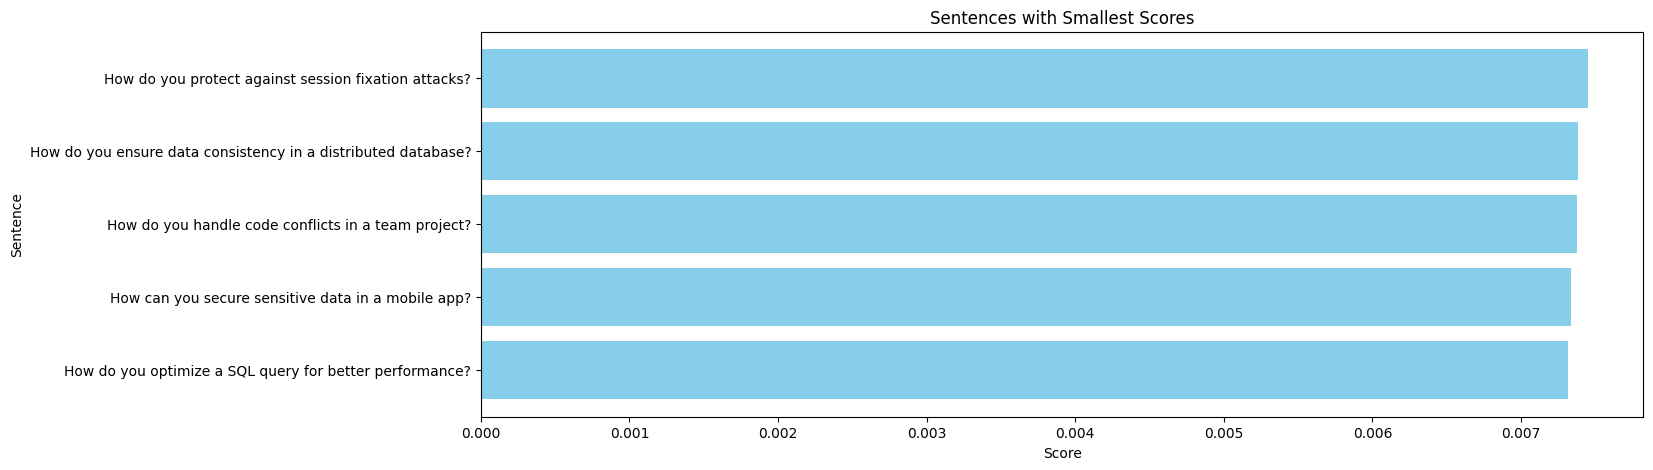

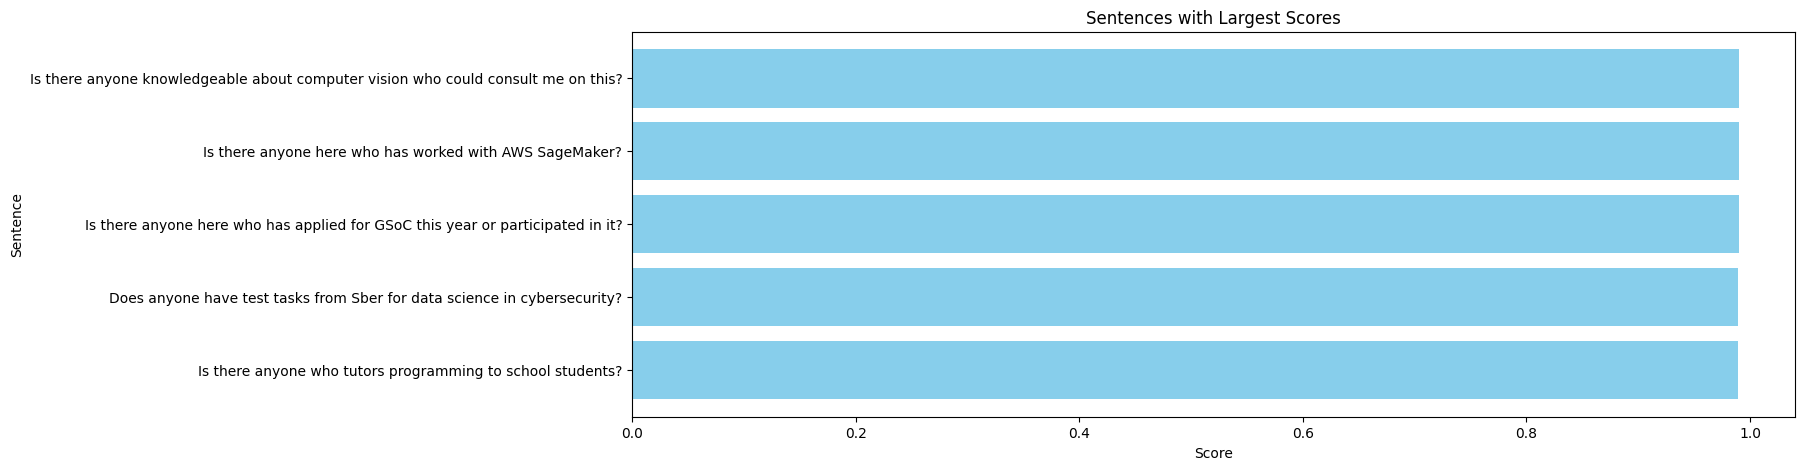

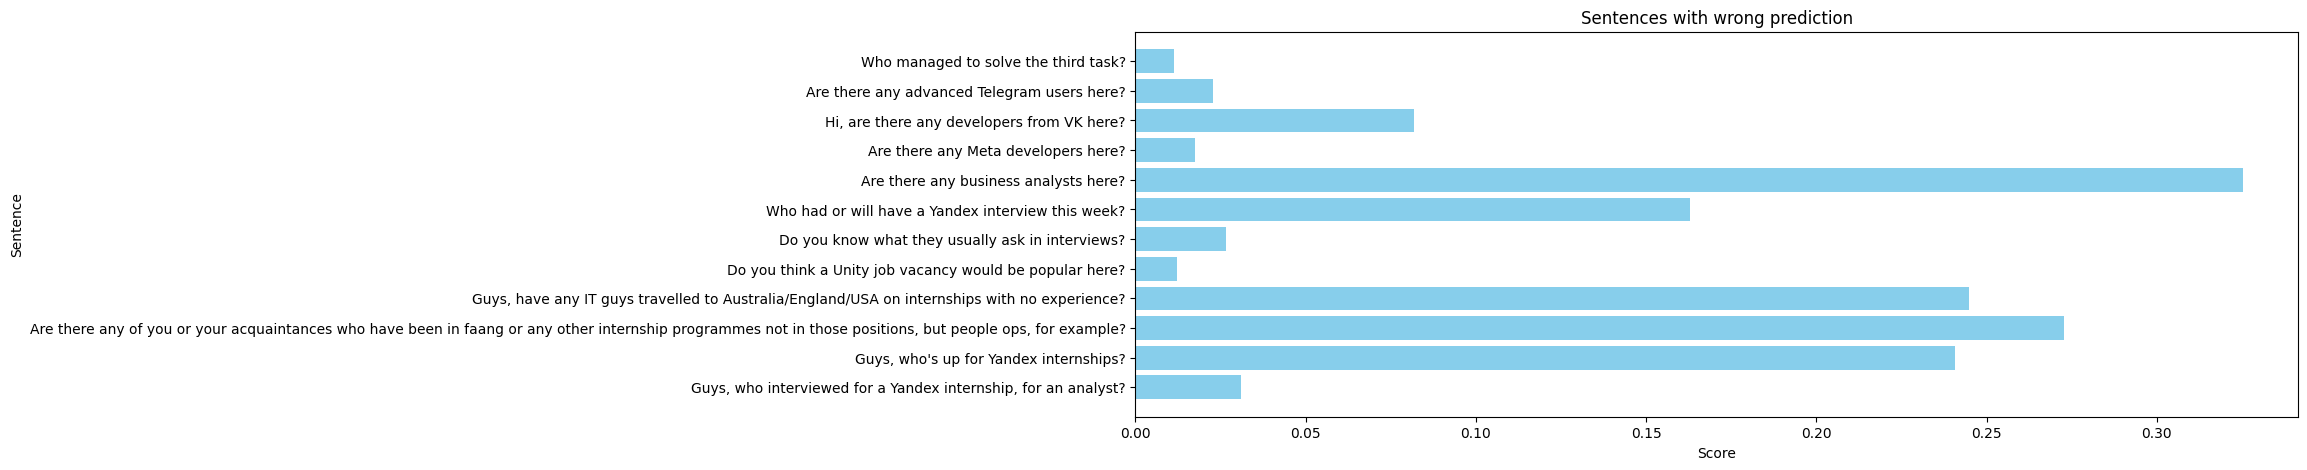

In [ ]:
visualize_scores(smallest_scores, 'Sentences with Smallest Scores')
visualize_scores(largest_scores, 'Sentences with Largest Scores')
visualize_scores(wrong, 'Sentences with wrong prediction')

In [ ]:
def get_attention(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors='pt').to('cuda')
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions
    return attentions

In [ ]:
def plot_all_attention_layers(tokens, attentions):
    num_layers = len(attentions)
    fig, axes = plt.subplots(2, 3, figsize=(30, 20))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for i, ax in enumerate(axes[:num_layers]):
        attention_matrix = attentions[i][0].cpu().detach().numpy().mean(axis=0)  # Average over all heads
        cax = ax.matshow(attention_matrix, cmap='viridis')
        # fig.colorbar(cax, ax=ax)
        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=90)
        ax.set_yticklabels(tokens)
        ax.set_title(f'Layer {i + 1}')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_random_question(df):
  q = df.sample(n=1).iloc[0]['question']
  attentions = get_attention(model, tokenizer, q)
  tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(q)))
  plot_all_attention_layers(tokens, attentions)

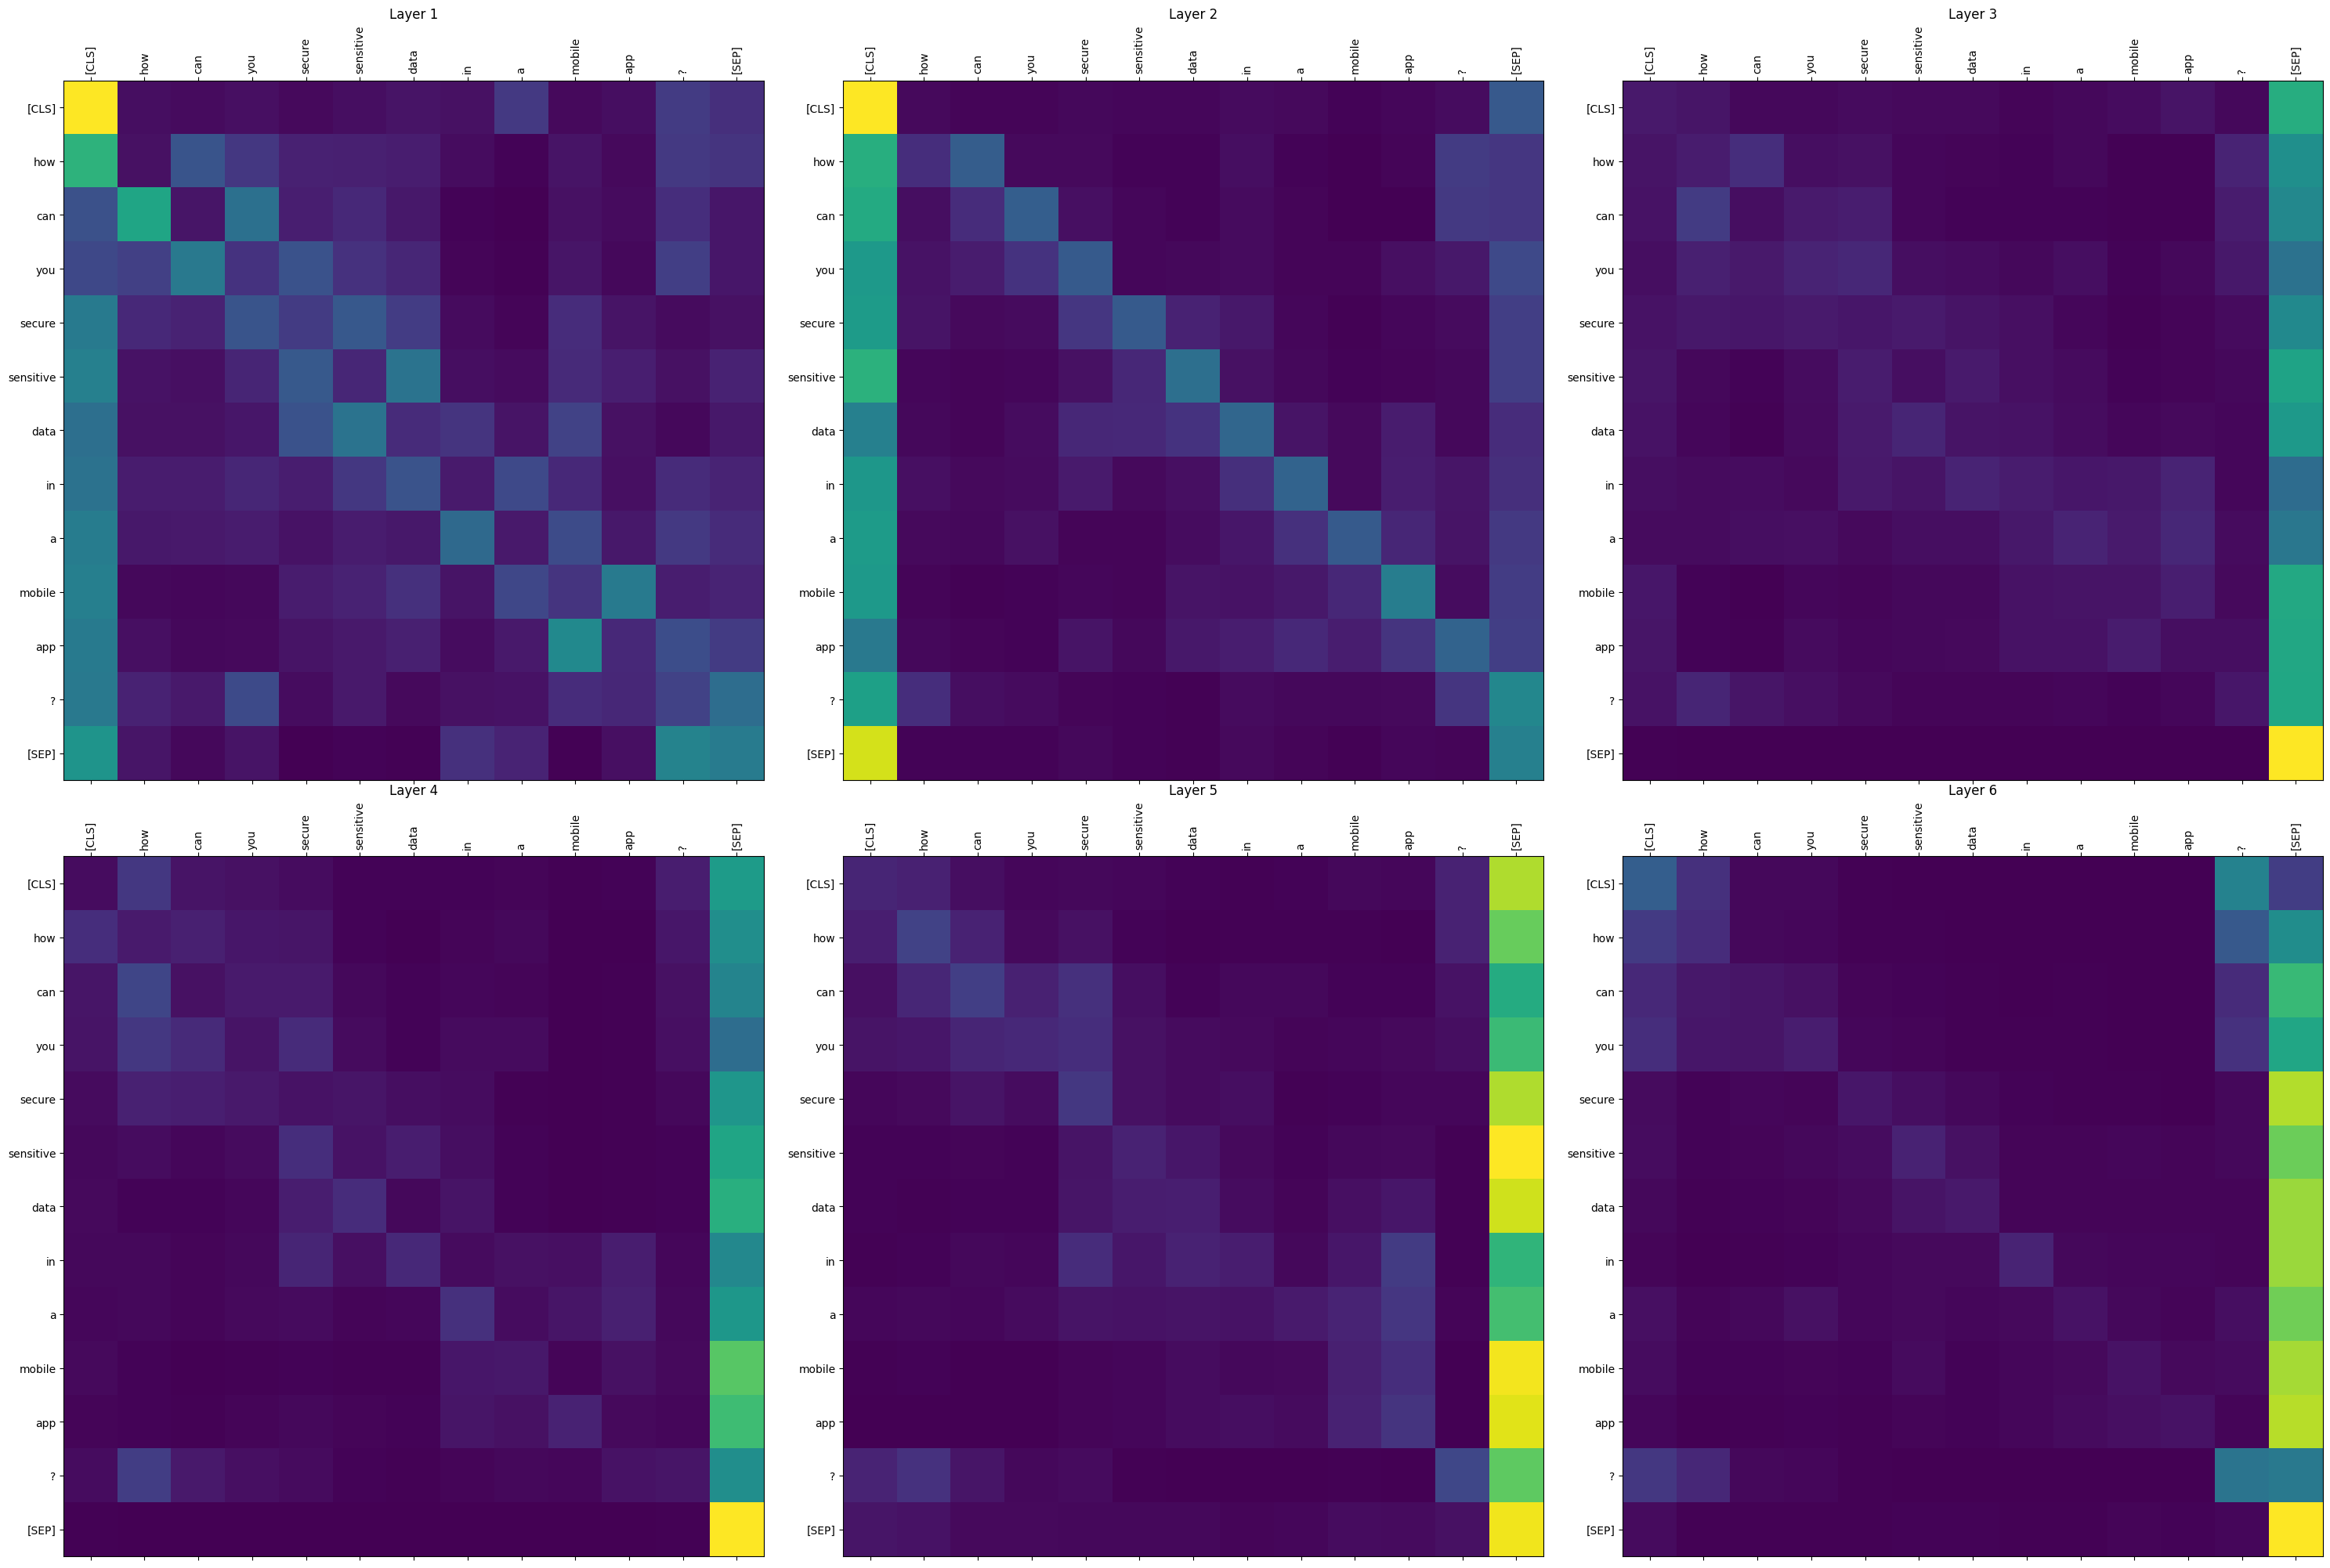

In [ ]:
plot_random_question(smallest_scores)

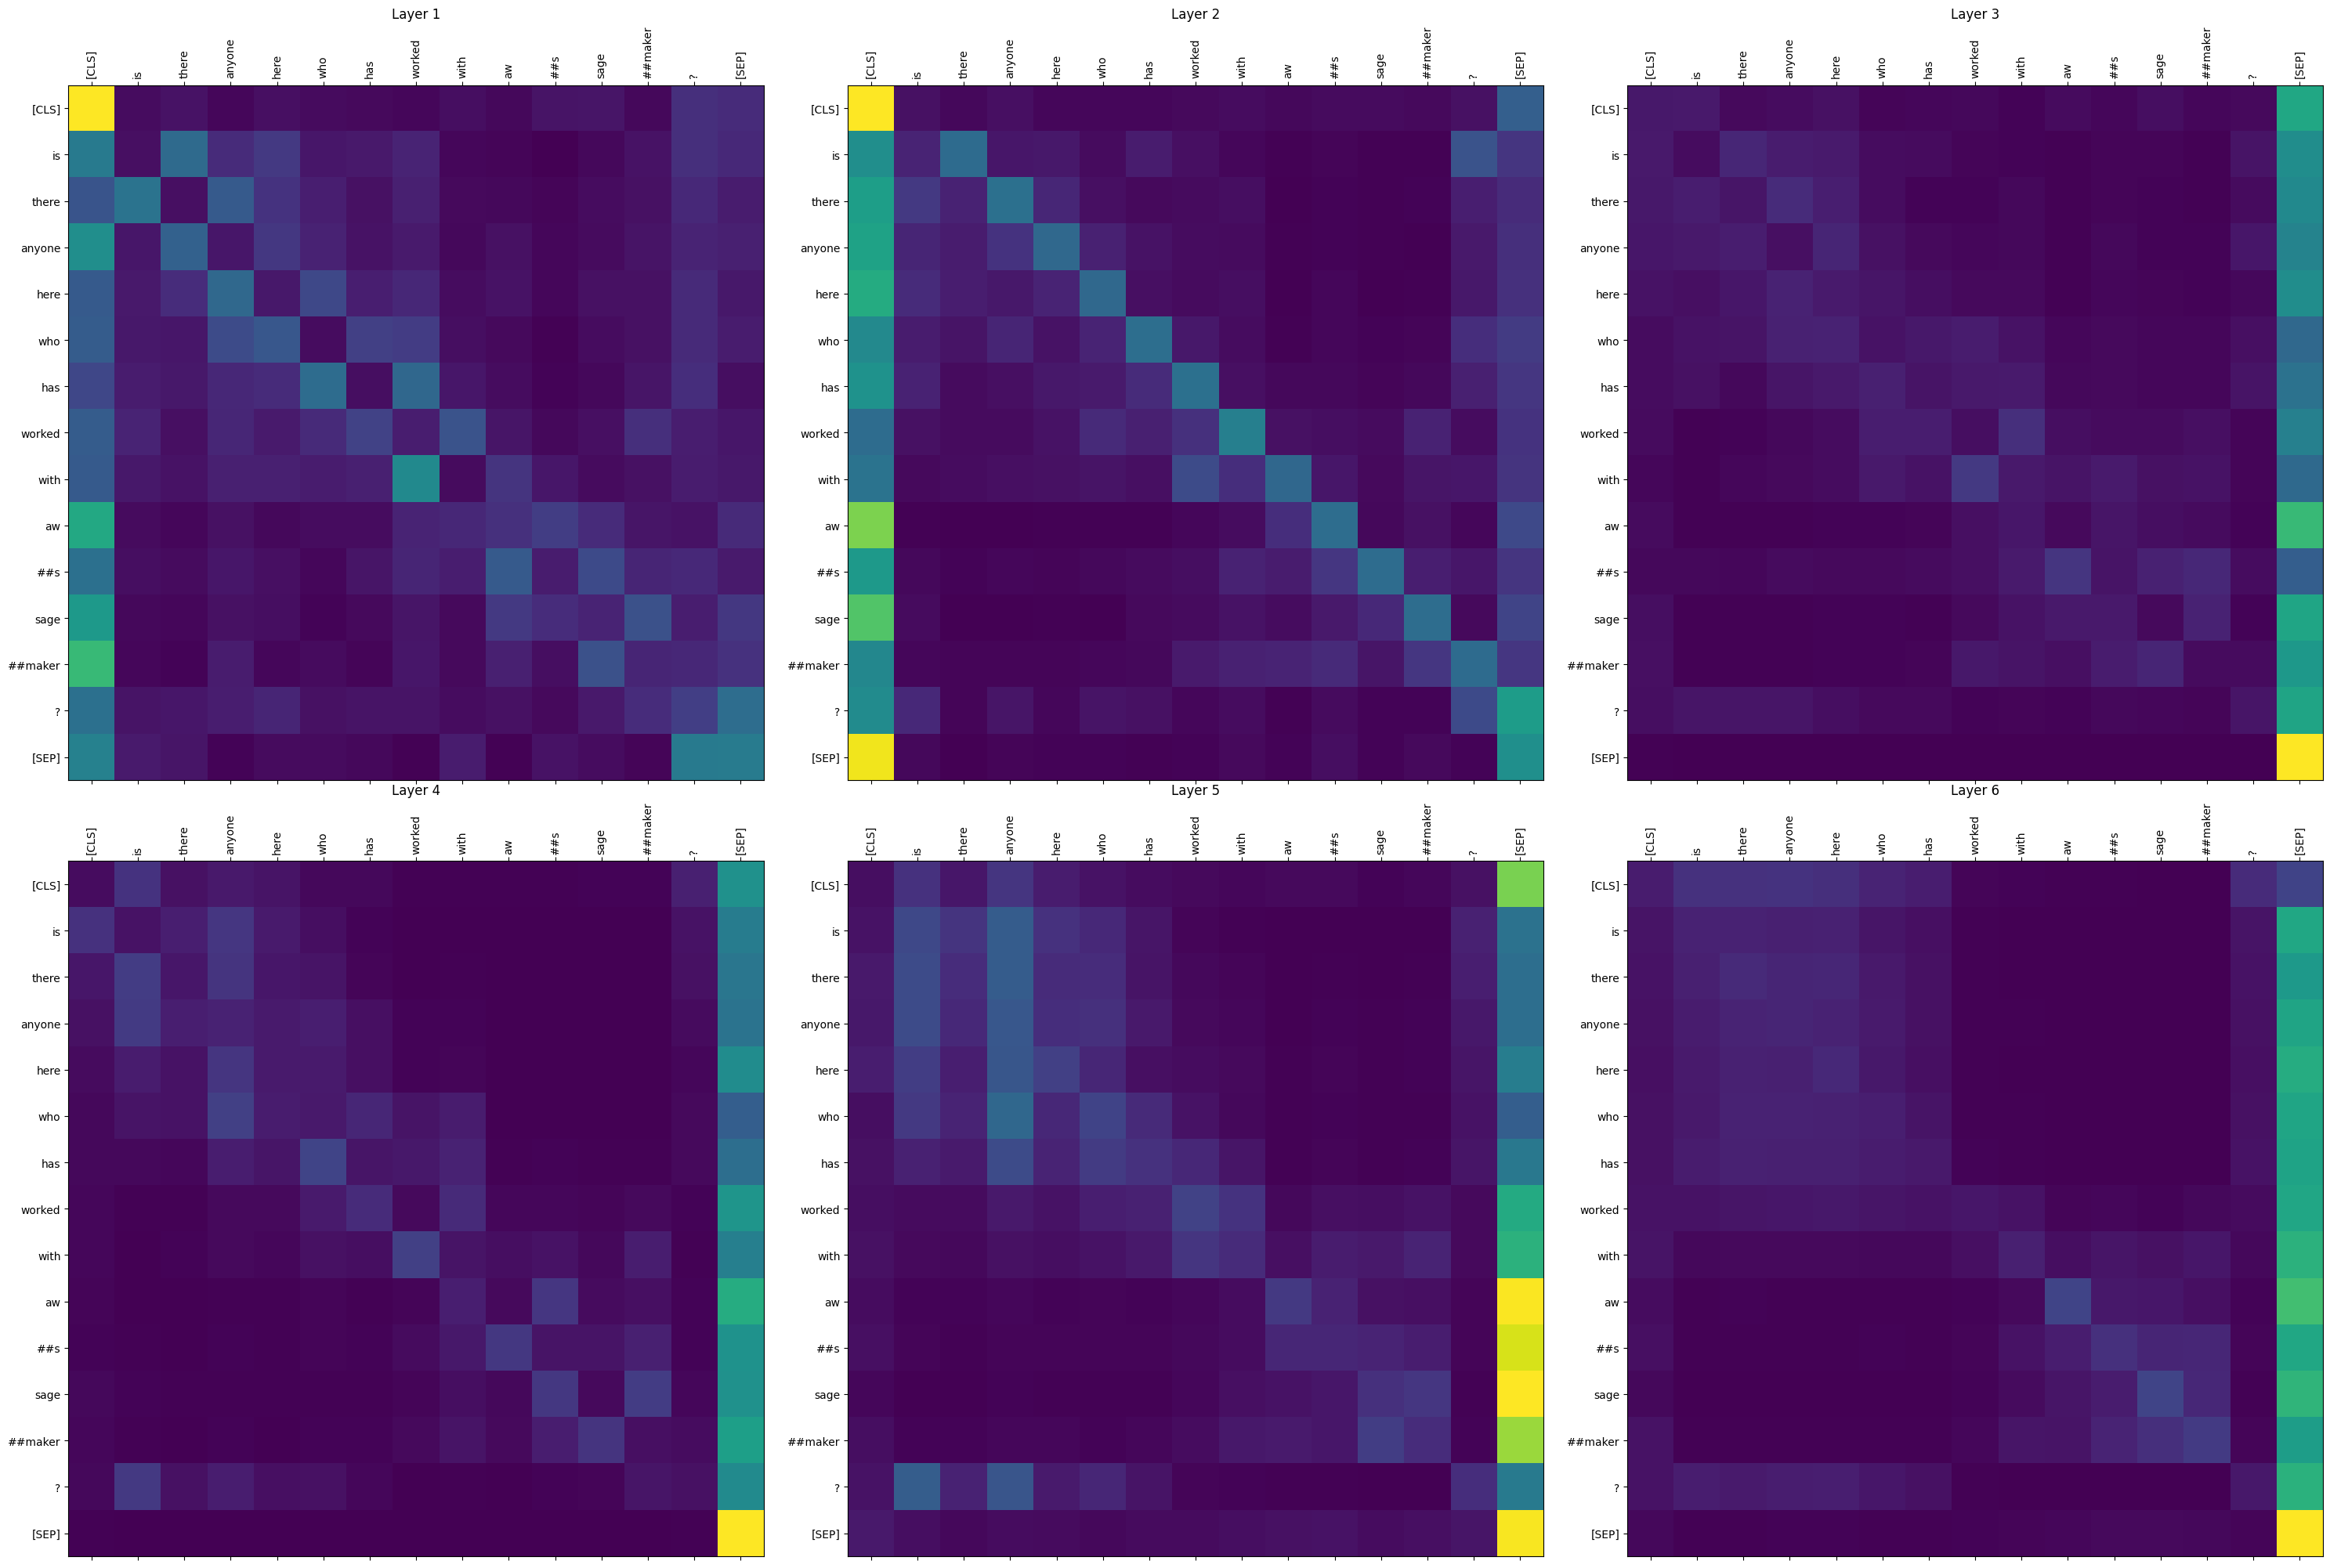

In [ ]:
plot_random_question(largest_scores)

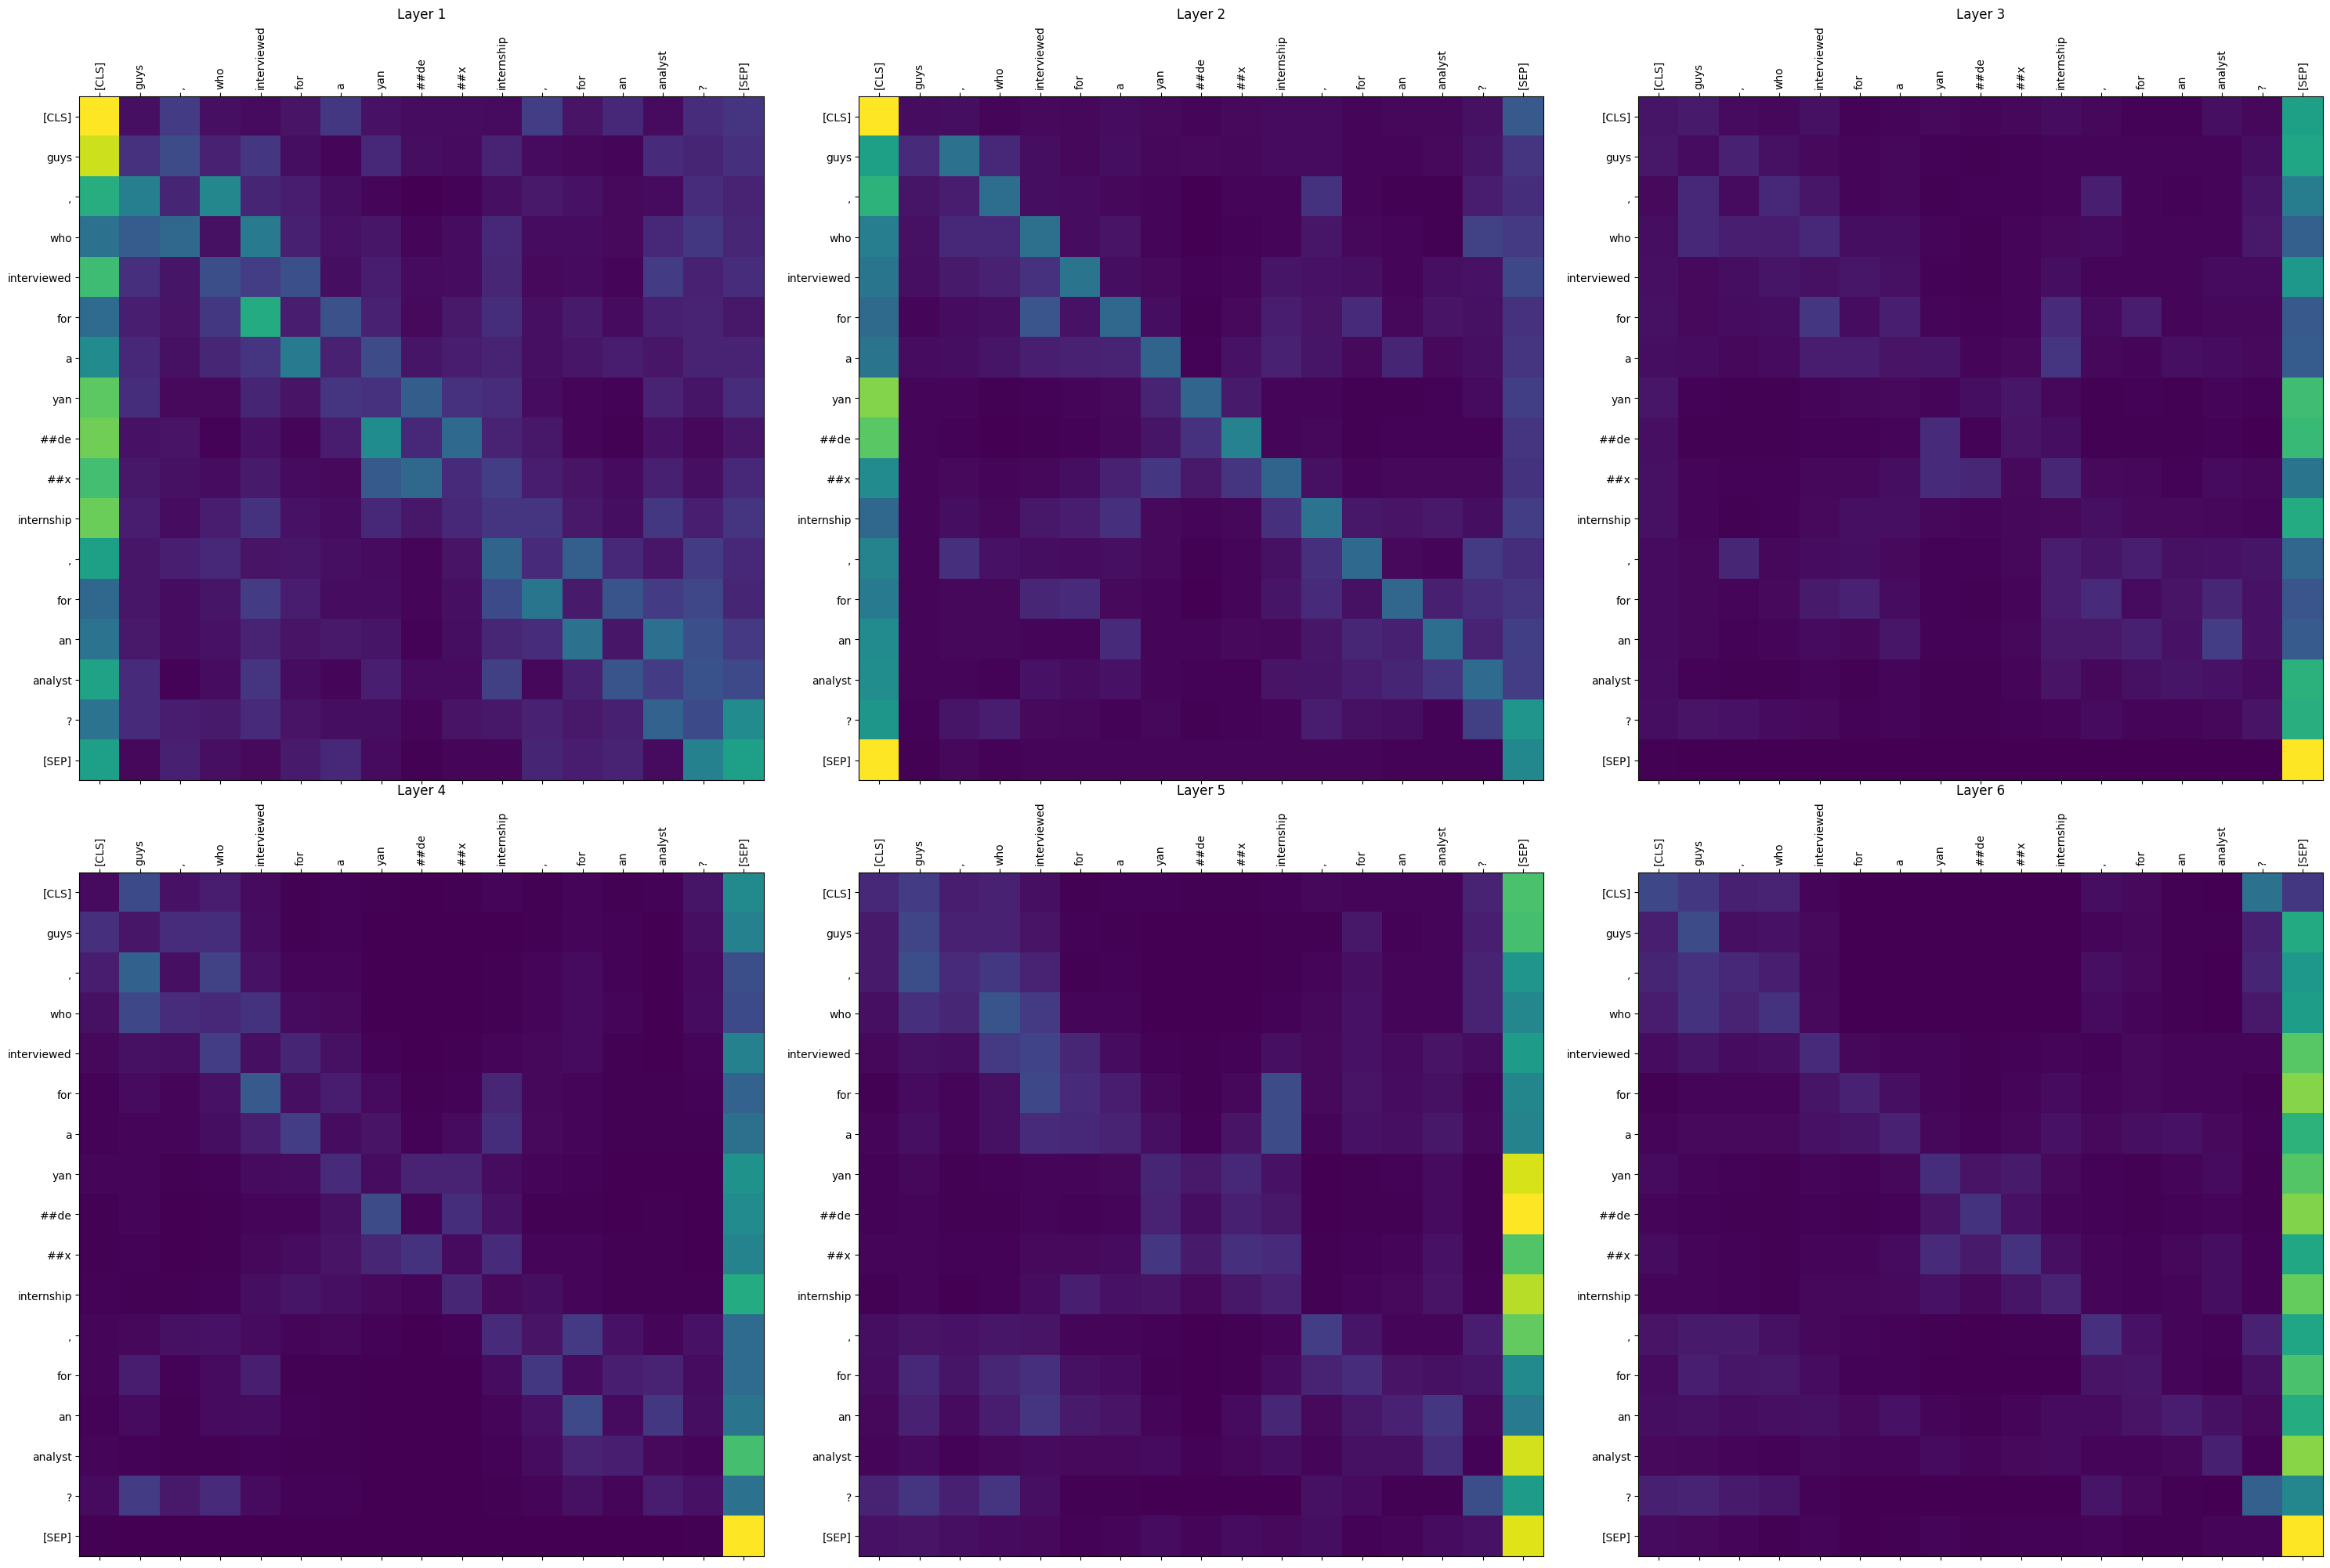

In [ ]:
plot_random_question(wrong)

# Yandex attack

In [ ]:
metaq = largest_scores.iloc[0]['question']
nometaq = smallest_scores.iloc[0]['question']

In [ ]:
metaq, nometaq

('Is there anyone who tutors programming to school students?',
 'How do you optimize a SQL query for better performance?')

In [ ]:
attack_df = pd.DataFrame(
    [{
        'question': metaq,
        'label': 'M'
    },
     {
        'question': 'How is there anyone who tutors programming to school students?',
        'label': 'M'
    },
     {
        'question': 'Is there anyone who tutors programming to school students here?',
        'label': 'M'
    },


     {
        'question': 'Is anyone here?',
        'label': 'M'
    },
     {
        'question': 'How?',
        'label': 'N'
    },

     {
        'question': nometaq,
        'label': 'N'
    },
     {
        'question': 'How do you optimize a SQL query for better performance at Yandex?',
        'label': 'N'
    },
     {
        'question': 'How do you optimize a SQL query in summer internship?',
        'label': 'N'
    },
     {
        'question': 'Is there a way to optimize a SQL query for better performance?',
        'label': 'N'
    },
    ]
)

In [ ]:
test_data = Dataset.from_pandas(attack_df)
tokenized_attack_data = test_data.map(test_preprocess, batched=True)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
get_scores(tokenized_attack_data)

[0.9893206357955933,
 0.860014021396637,
 0.9896385669708252,
 0.9558325409889221,
 0.013263224624097347,
 0.007313315290957689,
 0.007343284785747528,
 0.007481221575289965,
 0.01612997241318226]